<div style="background-color: lightblue;">
    
# Digital House - Data Science a Distancia

## Trabajo Final

### Autores: Daniel Borrino, Ivan Mongi, Jessica Polakoff, Julio Tentor
    
<p style="text-align:right;">Agosto 2022</p>

---
</div>    

---
# Objetivo del Trabajo Final

<h4 style="text-align:center;">Demostrar que aprendimos conceptos y desarrollamos habilidades para obtener un modelo de aprendizaje automático que razonablemente predice un valor</h4>

---
### Contexto

???
---
### Requisitos del Trabajo Final

- Utilizar modelos de regresión o clasificación (es opcional)
- Evaluar modelos mediante ensambles, bagging o boosting
- Realizar selección de hiperparámetros
- Implementar pipeline con al menos unos pasos del preprocesamiento
- Analizar importancia de características
- Serializar el modelo con mejor desempeño

---
### Entregables del Trabajo Final
#### Técnico (Jupyter Notebook)

1. Introducción y planteo del problema
2. Técnicas a utilizar y detalle del conjunto de datos
3. Desarrollo del análisis, visualizacioones, resultados de modelos
4. Dtelle de hallazgos, conclusiones y recomendaciones

#### Presentación (audiencia NO TÉCNICA)

1. Resumen del problema
2. Métodos utilizados
3. Principales resultados

---
#### Aspectos técnicos

La notebook se ejecuta correctamente en una instalación estándar de Anaconda versión *4.13.0 build  3.21.6, Python 3.9.7*


---

#### Necessary libraries


In [1]:
import pandas as pd
import numpy as np


In [2]:
# to avoid some warnings messages
import warnings
warnings.filterwarnings('ignore')


#### Style

In [3]:
# to draw some graphs
import seaborn as sns
import matplotlib.pyplot as plt

# set seaborn and matplotlib default theme
sns.set_theme()

_sns_plotting_contex_ = sns.plotting_context()

sns.plotting_context('poster')

# set seaborn and matplotlib style to ...
# plt.style.use('classic')

sns.mpl.rcParams['axes.titlesize'] = 18
sns.mpl.rcParams['axes.labelsize'] = 14


# to use HTML codes within IPpython.display function
from IPython.display import HTML


In [4]:
# to use in some statistical tests
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as st


In [5]:
# from sklearn.base import BaseEstimator, TransformerMixin

# from sklearn.base import RegressorMixin
# from sklearn.base import ClassifierMixin

# from sklearn.pipeline import Pipeline
# from sklearn import set_config
# set_config(display='diagram')

# from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

#
from sklearn.model_selection import train_test_split


# to use un Model Evaluation
from sklearn.naive_bayes import CategoricalNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# need for some models
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix


from sklearn.preprocessing import MultiLabelBinarizer


---

### Useful functions


In [6]:
def get_types_nulls_and_describe(data) :
    u''' Gets DataFrame data types, count of null values and statistical descriptions for each feature
    
    args
        data : pandas DataFrame

    returns
        pandas DataFrame
    '''

    result = data.describe(include='all').transpose()
    result.insert(0, 'nulls', data.isnull().sum().values)
    result.insert(0, 'types', data.dtypes)

    return result

def show_description(data, include='all', exclude=None) :
    u''' Show DataFrame describe details
    
    args
        data : pandas DataFrame

    returns
        None
    '''

    display(HTML('<hr><h4>Detalles de cada característica</h4>'))
    display(data.describe(include=include, exclude=exclude).transpose())
    
    return

def show_data(data) :
    u''' Show DataFrame
    
    args
        data : pandas DataFrame

    returns
        None
    '''
    display(HTML('<hr><h4>Algunos datos</h4>'))
    display(data)

    return    

def show_dataframe_basic_info(data) :
    u''' Show DataFrame basic information
    
    args
        data : pandas DataFrame

    returns
        None
    '''

    # shape
    display(HTML('<hr><h4>Cantidad de datos</h4>'))
    display(HTML('<h5>' + str(data.shape[0]) +' observaciones con ' + str(data.shape[1]) + ' características</h5>'))

    # data types, null values counts and data description
    display(HTML('<hr><h4>Tipos de datos, valores nulos y detalle de cada característica</h4>'))
    display(get_types_nulls_and_describe(data))

    return

In [7]:
def set_figure(row, col, suptitle=None) :
    u''' Activate matplot figure setting size and super title
    '''
    fig = plt.figure(figsize=(row, col));
    if suptitle != None :
        fig.suptitle(suptitle, 
                     verticalalignment='center', fontsize='xx-large', fontweight='extra bold');
    return fig

In [8]:
def show_corr(data, target) :
    u'''
    '''
    
    corr = data.corr()
    cols = corr[target].sort_values(ascending=False).keys()
    
    topc = corr.loc[cols, cols]
    mask = np.zeros_like(topc)
    mask[np.triu_indices_from(mask)] = True
    
    sns.heatmap(data=topc, 
                cmap=sns.diverging_palette(h_neg=350, h_pos=150, center='light', as_cmap=True), 
                center=0, linewidths=1, annot=True, fmt=".3f", cbar=False, mask=mask)

    return

def show_some_boxplots(data, columns, target=None, cols=4) :
    u''' Display some boxplots graphs for specific columns in dataset

    args
        data : dataset
        columns : series to show
        target : binary values to split the histogram; if None draw a simple histplot
        cols : number of columns for subplots
    
    Original from Flavio Cavalcante at https://www.kaggle.com/code/flaviocavalcante/simple-eda-to-start
    '''
    
    rows = (len(columns) // cols) + 1
    for i, column in enumerate(data[columns]) :
        ax = plt.subplot(rows, cols, i+1)
        sns.boxplot(data=data, x=target, y=column, palette="RdYlBu")
        plt.tight_layout();
        plt.xlabel(None);
        plt.ylabel(column);
    return

def show_some_hists(data, columns, target=None, cols=4, stat='count') :
    u''' Display some histograms graphs for specific columns in dataset

    args
        data : dataset
        columns : series to show 
        target : binary values to split the count; if None draw a simple histplot
        cols : number of columns for subplots
    
    Original from Flavio Cavalcante at https://www.kaggle.com/code/flaviocavalcante/simple-eda-to-start
    '''
    
    rows = (len(columns) // cols) + 1
    for i, column in enumerate(data[columns]) :
        try :
            plt.subplot(rows, cols, i+1)
            sns.histplot(data=data, x=column, kde=True, hue=target, stat=stat)
            plt.tight_layout();
            plt.xlabel(column);
            plt.ylabel(None);
        except :
            pass
    return

def show_some_plots(data, columns, target=None, cols=4) :
    u''' Display some countplots graphs for specific columns in dataset

    args
        data : dataset
        columns : series to count
        target : binary values to split the count; if None draw a simple countplot
        cols : number of columns for subplots
    
    Original from Flavio Cavalcante at https://www.kaggle.com/code/flaviocavalcante/simple-eda-to-start
    '''
    
    rows = (len(columns) // cols) + 1
    if target != None :
        rows *= 2
    for i, column in enumerate(data[columns]) :
        if target == None :
            plt.subplot(rows, cols, i+1)
            sns.countplot(y=data[column])
            plt.tight_layout();
            plt.xlabel(None);
        else :
            # standar count plot
            plt.subplot(rows, cols, i*2+1)
            sns.countplot(y=data[column])
            plt.tight_layout();
            plt.xlabel(None);
            
            # count by target values
            plt.subplot(rows, cols, i*2+2)
            sns.countplot(data=data, x=column, hue=target)
            plt.tight_layout();
            plt.xlabel(column);
    return

---



In [9]:

# This plain object class is only to support proof of concepts

class Model() :
    u''' Models plain object, used to keep values for each model
    '''
    
    def __init__(self, name, model, scaler=None) :
        u'''
        Object intializacion
        
        args
            name : text name of model
            model : model instance
            scaler : scaler instance, apply only if not None
        
        '''
    
        self.name = name
        self.model = model
        self.scaler = scaler
        self.isfit = False
        
        self.confusion = None
        self.classification_report = None
        
        return
    

    def train(self, X_data, y_data) :
        u'''
        Train model
        '''

        if self.scaler == None : # not need to scaler
            self.model.fit(X_data, y_data)
        else :
            self.model.fit(self.scaler.fit_transform(X_data), y_data)
        self.isfit = True
            
        return
    
    
    def predict(self, X_data, y_data, target_names=None) :
        u''' Predict values
        '''
        
        if not self.isfit :
            raise Exception('MODELO NO ENTRENADO ...')
            
        if self.scaler == None :
            y_pred = self.model.predict(X_data)
        else :
            y_pred = self.model.predict(self.scaler.fit_transform(X_data))
                
        self.confusion = metrics.confusion_matrix(y_data, y_pred)
        self.classification_report = metrics.classification_report(y_data, y_pred,
                                                                   digits=6, 
                                                                   target_names=target_names, 
                                                                   output_dict=False)

        return y_pred
#


In [10]:
from imblearn.under_sampling import RandomUnderSampler


def evaluate_some_models(data, features, target, target_names=None) :
    
    # set
    X = data[features]
    y = data[target]

    undersampler = RandomUnderSampler(sampling_strategy='majority',random_state=123)
    X_us, y_us = undersampler.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.33, random_state=1)
    
    

    print("X_train:", X_train.shape)
    print("y_train:", y_train.shape)
    print("X_test: ", X_test.shape)
    print("y_test :", y_test.shape)    

    # set models to evaluate
    models = []
    models.append( Model(name='Naive Bayes Categorical', model=CategoricalNB(), ) )
    # models.append( Model(name='Árbol de Decisión', model=DecisionTreeClassifier(random_state=0) ) )
    models.append( Model(name='Gradiente Booster', model=GradientBoostingClassifier() ) )

    # train each model
    for m in models :
        m.train(X_train, y_train)

    # predict and show basic information from each model
    for m in models :
        m.predict(X_test, y_test, target_names=target_names)
        display(HTML('<b>' + m.name + '</b>'))
        print(m.classification_report)

    return


---
<a id="Dataset"></a>

### Conjunto de datos - Dataset

Los datos originales son de [Manhattan Chocolate Society](http://flavorsofcacao.com/mcs_index.html)

El conjunto de datos se obtuvo de la [competencia en Datacamp](https://app.datacamp.com/learn/competitions/chocolate-bar-ratings) finalizada el 30 de junio de 2022.

---

*Las características en el conjunto de datos original son*:

    - id                   : Identificador de la revisión de la barra de chocolate
    - manufacturer         : Nombre del manufactorador de la barra de chocolate
    - company_location     : Ubicación del manufactorador de la barra de chocolate
    - year_reviewed        : Año de la revisión de 2006 al 2021
    - bean_origin          : Origen del grano de cacaco
    - bar_name             : Nombre de la barra de chocolate
    - cocoa_percent        : Porcentaje de cacaco en la barra de chocolate
    - num_ingredients      : Número de ingredientes en la barra de chocolate
    - ingredients          : Ingredientes (ver codificación)
    - review               : Revisión, análisis o evaluación de la barra de chocolate
    - rating               : Clasificación (ver escala)
    

*Codificación de ingredientes en la barra de chocolate*

    - B  : Beans (grano)
    - S  : Sugar (azucar)
    - S* : Sweetener (edulcolrante distinto de azucar)
    - C  : Cocoa Butter (mantequilla de cacaco)
    - V  : Vanilla (vainilla)
    - L  : Lecithin (lecitina)    
    - Sa : Salt (sal)

*Escala de clasificación de una barra de chocolate*

    - 1.0  a 1.9  : Unpleasant (Desagradable)
    - 2.0  a 2.9  : Disappointing (Decepcionante)
    - 3.0  a 3.49 : Recommended (Recomendable)
    - 3.5  a 3.9  : Highly Recommended (Altamente Recomendable)
    - 4.0  a 5.0  : Oustanding (Sobresaliente)

---


---
<a id="Exploratory_data_analysis_01"></a>
### Exploración y análisis de datos básico del Conjunto de datos - Dataset
---


In [11]:
# read dataset
data = pd.read_csv('./data/chocolate_bars.csv')

# remove duplicates
data.drop_duplicates(inplace=True)
# set sequential and successive index values
data.reset_index(drop=True, inplace=True)

# shape
display(HTML('<hr><h4>Cantidad de datos</h4>'))
display(HTML('<h5>' + str(data.shape[0]) +' observaciones con ' + str(data.shape[1]) + ' características</h5>'))

# data types, null values counts and data description
display(HTML('<hr><h4>Tipos de datos, valores nulos y detalle de cada característica</h4>'))
display(get_types_nulls_and_describe(data))

# show data
show_data(data)


,types,nulls,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,2530.0,NaN,NaN,NaN,1429.800791,757.648556,5.0,802.0,1454.0,2079.0,2712.0
manufacturer,object,0,2530,580,Soma,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_location,object,0,2530,67,U.S.A.,1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_reviewed,int64,0,2530.0,NaN,NaN,NaN,2014.374308,3.968267,2006.0,2012.0,2015.0,2018.0,2021.0
bean_origin,object,0,2530,62,Venezuela,253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bar_name,object,0,2530,1605,Madagascar,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cocoa_percent,float64,0,2530.0,NaN,NaN,NaN,71.639723,5.616724,42.0,70.0,70.0,74.0,100.0
num_ingredients,float64,87,2443.0,NaN,NaN,NaN,3.041343,0.913728,1.0,2.0,3.0,4.0,6.0
ingredients,object,87,2443,21,"B,S,C",999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review,object,0,2530,2487,"spicy, cocoa",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,id,manufacturer,company_location,year_reviewed,bean_origin,bar_name,cocoa_percent,num_ingredients,ingredients,review,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,3.0,"B,S,C","rich cocoa, fatty, bready",3.25
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,3.0,"B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,3.0,"B,S,C","cocoa, blackberry, full body",3.75
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68.0,3.0,"B,S,C","chewy, off, rubbery",3.00
4,2546,5150,U.S.A.,2021,Venezuela,"Sur del Lago, batch 1",72.0,3.0,"B,S,C","fatty, earthy, moss, nutty,chalky",3.00
...,...,...,...,...,...,...,...,...,...,...,...
2525,1205,Zotter,Austria,2014,Blend,Raw,80.0,4.0,"B,S*,C,Sa","waxy, cloying, vegetal",2.75
2526,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75.0,3.0,"B,S,C","strong nutty, marshmallow",3.75
2527,2036,Zotter,Austria,2018,Blend,"Dry Aged, 30 yr Anniversary bar",75.0,3.0,"B,S,C","fatty, earthy, cocoa",3.00
2528,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70.0,3.0,"B,S,C","fatty, mild nuts, mild fruit",3.25


---
#### Observaciones sobre las características con valores nulos

- La característica 'ingredients' se puede completar con el **valor más frecuente**
- La característica 'num_ingredients' corresponde al **número de valores diferentes de la característica 'ingredients'**, es posible completar con este valor

---

In [12]:
def ingredients_imputer(data) :
    u''' Imputer for 'ingredients' and 'num_ingredients' features
    
    WARNING: this function update data DataFrame
    ============================================
    
    Original idea from Shahriar Rahman https://app.datacamp.com/profile/mdshahriar983
    '''
    
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer.fit(data[['ingredients']])
    data[['ingredients']] = imputer.transform(data[['ingredients']])
    data['num_ingredients'] = data['ingredients'].apply( lambda x : len( [t for t in x.replace(' ','').split(sep=',')] ) )
    
    return 

ingredients_imputer(data)

In [13]:
# data types and null values counts
display(HTML('<hr><h4>Tipos de datos, SIN VALORES NULOS y detalle de cada característica</h4>'))
display(get_types_nulls_and_describe(data))


,types,nulls,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,int64,0,2530.0,NaN,NaN,NaN,1429.800791,757.648556,5.0,802.0,1454.0,2079.0,2712.0
manufacturer,object,0,2530,580,Soma,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_location,object,0,2530,67,U.S.A.,1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_reviewed,int64,0,2530.0,NaN,NaN,NaN,2014.374308,3.968267,2006.0,2012.0,2015.0,2018.0,2021.0
bean_origin,object,0,2530,62,Venezuela,253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bar_name,object,0,2530,1605,Madagascar,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cocoa_percent,float64,0,2530.0,NaN,NaN,NaN,71.639723,5.616724,42.0,70.0,70.0,74.0,100.0
num_ingredients,int64,0,2530.0,NaN,NaN,NaN,3.039921,0.897906,1.0,2.0,3.0,4.0,6.0
ingredients,object,0,2530,21,"B,S,C",1086,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review,object,0,2530,2487,"spicy, cocoa",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
#### Observaciones

- **NO hay** *características con valores nulos*
- La característica 'manufacturer' indica muchas compañías, al rededor de un quinto de las observaciones; **no parece ser representativo**
- Las características 'company_location' y 'bean_origin' indican el país de la compañía y orígen del grano de cocoa; **¿son las mismas o diferentes?, ¿tienen alguna relación entre ellas y/o el valor de clasificación?**
- La característica 'ingredients' presenta 21 combinaciones diferentes; **¿todas son representativas?, ¿existe una relación particular con el valor de clasificación?**
---

---

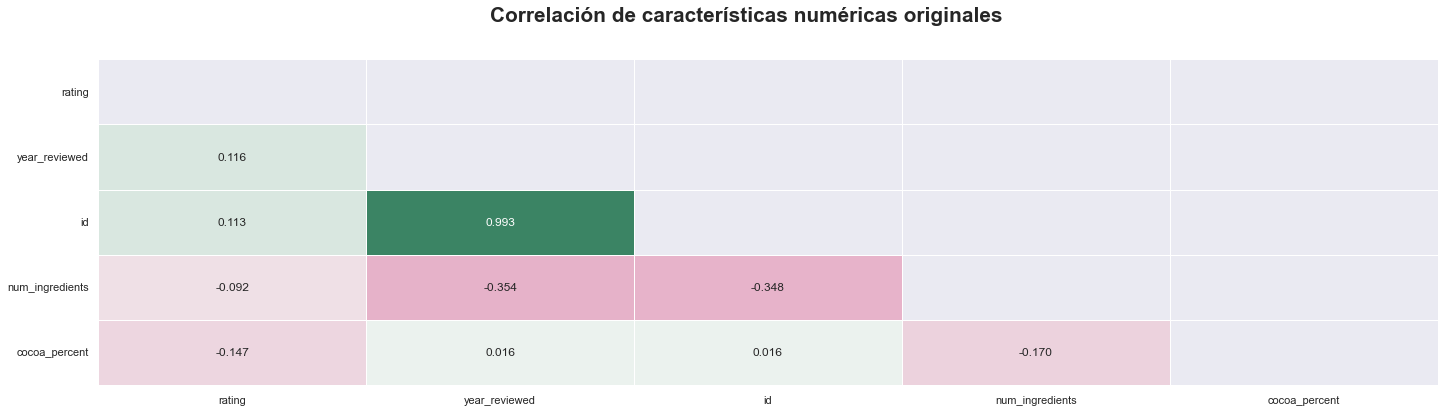

In [14]:

set_figure(24, 6, 'Correlación de características numéricas originales')
show_corr(data=data, target='rating')


---
#### Observaciones

- Existe una debil correlación entre 'raiting' y las otras características
- Existe una fuerte correlación entre 'year_reviewed' y 'id'; **¿son dependientes?**

---

In [15]:
def year_reviewed_hypotest(data) :
    u''' Hypothesis test
    
    H0: There is no significant difference between year_reviewed and the id
    Ha: There is a significant difference between year_reviewed and the id
    Independent variable: id
    Dependent variable: year_reviewed

    '''

    model = ols('year_reviewed ~ id', data = data).fit()
    results = sm.stats.anova_lm(model, typ = 2)
    display(HTML('<h4>ANOVA : year_reviewed ~ id</h4>'))
    display(results)
    
    return

year_reviewed_hypotest(data)

,sum_sq,df,F,PR(>F)
id,39278.869468,1.0,181975.732097,0.0
Residual,545.660572,2528.0,NaN,NaN


---
#### Observaciones

- Las características 'year_reviewed' e 'id' están **significativamente relacionadas** con un nivel de confianza del 95%
- Es posible ignorar 'id'

---

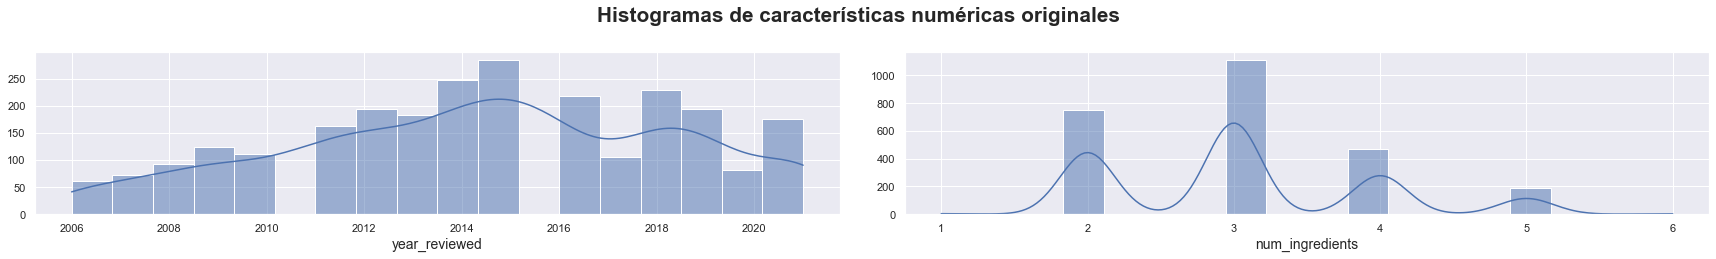

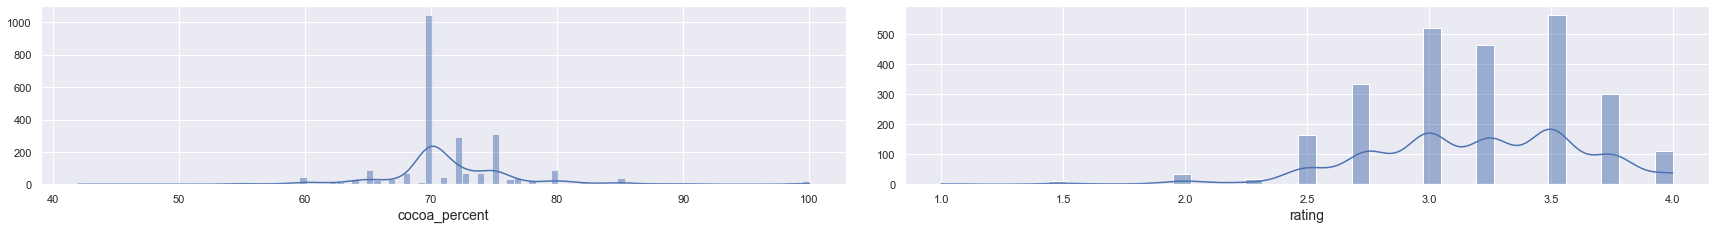

In [16]:

set_figure(24, 6, 'Histogramas de características numéricas originales')
show_some_hists(data=data, columns=['year_reviewed', 'num_ingredients'], target=None, cols=2, stat='count')

set_figure(24, 6)
show_some_hists(data=data, columns=['cocoa_percent', 'rating'], target=None, cols=2, stat='count')


---
#### Observaciones

- Existe variación en la cantidad de observaciones por año; **¿impacta en la clasificación?**
- La cantidad de ingredientes más frecuente se encuentra en la mitad de las observaciones; **¿impacta en la clasificación?**
- El porcentaje de cocoa más frecuente se encuentra en la mitad de las observaciones; **¿impacta en la clasificación?**
- Los valores de clasificación (raiting) se encuentran entre 2.7 y 3.6; **¿está desbalanceada la clasificación?**

---

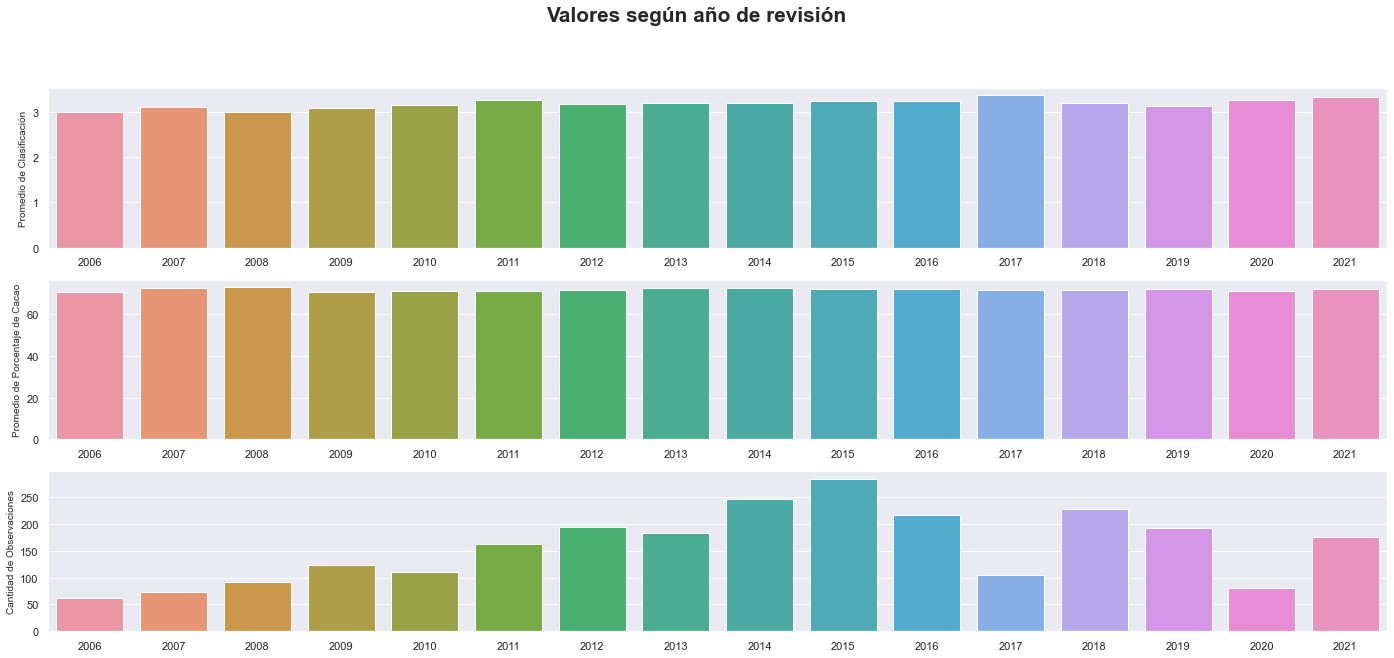

In [17]:
# TODO: review graphs visualization
def year_reviewed_EDA1(data) :

    work = pd.DataFrame(data.groupby('year_reviewed').mean()[['rating', 'cocoa_percent']])
    work['count'] = pd.DataFrame(data.groupby('year_reviewed').count()['rating'])['rating']
    work.reset_index(drop=False, inplace=True)
    work['labels'] = work['year_reviewed'].apply(lambda x : str(x))
    
    fig = set_figure(24, 10, 'Valores según año de revisión')
    
    plt.subplot(3, 1, 1)
    sns.barplot(data=work, x='labels', y='rating')
    # sns.lineplot(data=work, x='labels', y='rating')
    plt.xlabel(None);
    plt.ylabel('Promedio de Clasificación', fontdict={'size':10});

    plt.subplot(3, 1, 2)
    sns.barplot(data=work, x='labels', y='cocoa_percent')
    # sns.lineplot(data=work, x='labels', y='cocoa_percent')
    plt.xlabel(None);
    plt.ylabel('Promedio de Porcentaje de Cacao', fontdict={'size':10});
    
    plt.subplot(3, 1, 3)
    sns.barplot(data=work, x='labels', y='count')
    plt.xlabel(None);
    plt.ylabel('Cantidad de Observaciones', fontdict={'size':10});
    
    return

year_reviewed_EDA1(data)


---
#### Observaciones *algo para decir sobre year_reviewed ...*

- ???

---

In [18]:

# set_figure(24, 30, 'Cuentas de características originales\n')
# show_some_plots(data=data, columns=['company_location', 'bean_origin'],
#                 target=None, cols=2)

# set_figure(24, 16)
# show_some_plots(data=data, columns=['ingredients'],
#                 target=None, cols=1)


---

In [19]:

def rating_EDA1(data) :
    u'''
    '''
    
    data['rating_cat'] = data['rating'].apply( lambda x : 0 if x <= 2.9 else 1 )
    # raiting_dict = {0:'Low Quality', 1:'High Quality'}
    # raiting_names = ['Low Quality', 'High Quality']
    data['rating_name'] = data['rating_cat'].map({0:'Low Quality', 1:'High Quality'})
    data = data.astype({'rating_cat' : 'category'})

    return data

#
data = rating_EDA1(data)


---
### Evaluate base line models
---

In [20]:

target = 'rating_cat'
target_names = ['Low Quality', 'High Quality']

categorical_features = ['manufacturer', 'company_location', 'bean_origin', 'bar_name', 'ingredients']

numeric_features = ['cocoa_percent']
ordinal_features = ['year_reviewed', 'num_ingredients']

other_features = ['review']

base_line_features = numeric_features + ordinal_features

display(HTML('<hr><h4>Evaluación Línea Base</h4>'))

evaluate_some_models(data, base_line_features, target, target_names)


X_train: (758, 3)
y_train: (758,)
X_test:  (374, 3)
y_test : (374,)


              precision    recall  f1-score   support

 Low Quality   0.572917  0.611111  0.591398       180
High Quality   0.615385  0.577320  0.595745       194

    accuracy                       0.593583       374
   macro avg   0.594151  0.594215  0.593571       374
weighted avg   0.594945  0.593583  0.593653       374



              precision    recall  f1-score   support

 Low Quality   0.575419  0.572222  0.573816       180
High Quality   0.605128  0.608247  0.606684       194

    accuracy                       0.590909       374
   macro avg   0.590274  0.590235  0.590250       374
weighted avg   0.590830  0.590909  0.590865       374



---
---
---


In [21]:
ingredients_dict = {'b'  : 'beans',
                    'c'  : 'cocoa_butter',
                    'l'  : 'lecithin',
                    's'  : 'sugar',
                    's*' : 'sweetener',
                    'sa' : 'salt',
                    'v'  : 'vanilla'}

ingredients_features = list(ingredients_dict.values())


def ingredients_EDA1(data) :
    u''' 
    
    
    '''
    
    col='ingredients'
    work = pd.DataFrame(data[col])
    work['text'] = work[col].apply( lambda x : set( [t for t in x.lower().replace(' ','').split(sep=',')] ) )

    classes = np.array(list(ingredients_dict.keys()))
    mlb = MultiLabelBinarizer(classes=classes)
    work = pd.DataFrame(mlb.fit_transform(work['text']))
    work.columns = mlb.classes_
    
    work.rename(columns=ingredients_dict, inplace=True)
    work.index = data.index
    
    cols = list(data.columns) + list(work.columns)
    data = pd.concat([data, work], axis='columns', ignore_index=True)
    data.columns = cols
    
    return data

data = ingredients_EDA1(data)



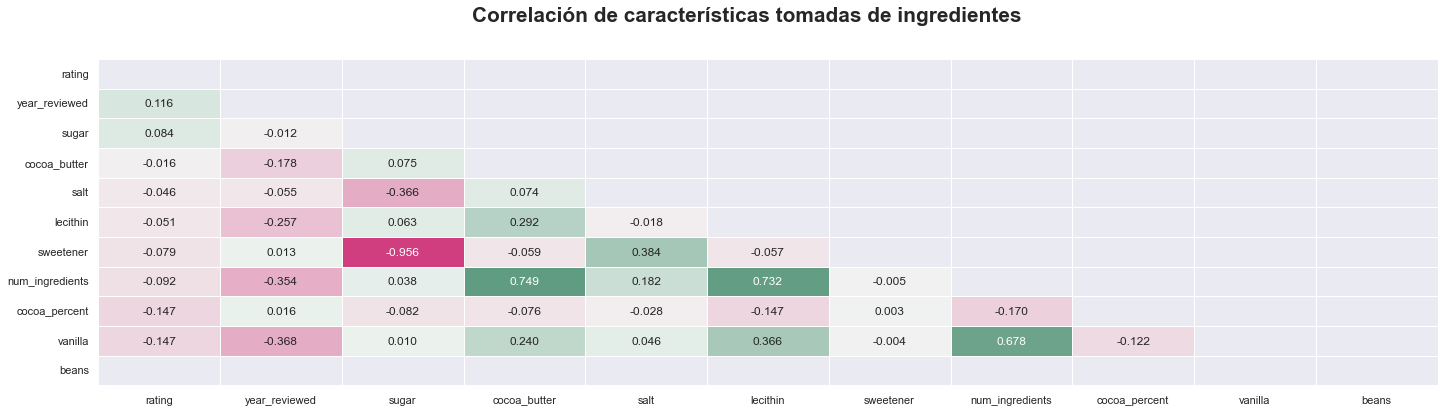

In [22]:
set_figure(24, 6, 'Correlación de características tomadas de ingredientes')
show_corr(data=data.drop(columns=['id']), target='rating')


In [23]:
data

,id,manufacturer,company_location,year_reviewed,bean_origin,bar_name,cocoa_percent,num_ingredients,ingredients,review,rating,rating_cat,rating_name,beans,cocoa_butter,lecithin,sugar,sweetener,salt,vanilla
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,3,"B,S,C","rich cocoa, fatty, bready",3.25,1,High Quality,1,1,0,1,0,0,0
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,3,"B,S,C","cocoa, vegetal, savory",3.50,1,High Quality,1,1,0,1,0,0,0
2,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,3,"B,S,C","cocoa, blackberry, full body",3.75,1,High Quality,1,1,0,1,0,0,0
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68.0,3,"B,S,C","chewy, off, rubbery",3.00,1,High Quality,1,1,0,1,0,0,0
4,2546,5150,U.S.A.,2021,Venezuela,"Sur del Lago, batch 1",72.0,3,"B,S,C","fatty, earthy, moss, nutty,chalky",3.00,1,High Quality,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,1205,Zotter,Austria,2014,Blend,Raw,80.0,4,"B,S*,C,Sa","waxy, cloying, vegetal",2.75,0,Low Quality,1,1,0,0,1,1,0
2526,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75.0,3,"B,S,C","strong nutty, marshmallow",3.75,1,High Quality,1,1,0,1,0,0,0
2527,2036,Zotter,Austria,2018,Blend,"Dry Aged, 30 yr Anniversary bar",75.0,3,"B,S,C","fatty, earthy, cocoa",3.00,1,High Quality,1,1,0,1,0,0,0
2528,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70.0,3,"B,S,C","fatty, mild nuts, mild fruit",3.25,1,High Quality,1,1,0,1,0,0,0


---
#### Observaciones *algo para decir sobre ingredients ...*

- ???

---

---
### Evaluate feature engineering 1st iteration models
---

In [24]:

target = 'rating_cat'
target_names = ['Unpleasant', 'Disappointing', 'Recommended', 'Highly Recommended', 'Oustanding']
target_names = None

categorical_features = ['manufacturer', 'company_location', 'bean_origin', 'bar_name', 'ingredientes', 'review']
numeric_features = ['cocoa_percent']
ordinal_features = ['year_reviewed', 'num_ingredients']

base_line_features = numeric_features + ordinal_features + ingredients_features

display(HTML('<hr><h4>Evaluación 1er iteración en ingeniería de características</h4>'))
evaluate_some_models(data, base_line_features, target, target_names)


X_train: (758, 10)
y_train: (758,)
X_test:  (374, 10)
y_test : (374,)


              precision    recall  f1-score   support

           0   0.605556  0.605556  0.605556       180
           1   0.634021  0.634021  0.634021       194

    accuracy                       0.620321       374
   macro avg   0.619788  0.619788  0.619788       374
weighted avg   0.620321  0.620321  0.620321       374



              precision    recall  f1-score   support

           0   0.606061  0.555556  0.579710       180
           1   0.617225  0.664948  0.640199       194

    accuracy                       0.612299       374
   macro avg   0.611643  0.610252  0.609954       374
weighted avg   0.611852  0.612299  0.611086       374



In [25]:
countries_dict = {'Tanzania': 'Africa', 'Dominican Republic':'North America', 
                  'Madagascar':'Africa', 'Fiji':'Oceania','Venezuela': 'South America', 
                  'Uganda':'Africa','India':'Asia', 'Bolivia':'South America', 
                  'Peru':'South America', 'Panama' : 'North America', 'Colombia':'South America', 
                  'Burma' :'Asia', 'Brazil':'South America', 'Papua New Guinea': 'Oceania', 
                  'Ecuador':'South America', 'Cuba':'South America', 'Togo':'Africa', 
                  'Sao Tome':'Africa', 'Mexico':'North America','Vanuatu': 'Oceania', 
                  'Indonesia':'Asia', 'Trinidad':'South America', 'Vietnam':'Asia', 
                  'Nicaragua' : "North America", 'Ghana':'Africa', 'Belize':'North America', 
                  'Blend':'Africa', 'Jamaica':'North America', 'Grenada':'North America', 
                  'Guatemala':'North America', 'Honduras':'North America', 'Costa Rica':'North America', 
                  'Haiti':'North America', 'Congo':'Africa', 'Philippines':'Asia', 'Solomon Islands':'Oceania', 
                  'Malaysia':'Asia', 'Sri Lanka':'Asia', 'Ivory Coast':'Africa', 
                  'Gabon':'Africa', 'Taiwan':'Asia', 'Puerto Rico':'North America', 
                  'Martinique':'North America', 'St. Lucia':'North America', 'Australia' : 'Oceania', 
                  'Liberia': 'Africa', 'Sierra Leone':'Africa', 'Nigeria':'Africa', 
                  'U.S.A.':'North America', 'St.Vincent-Grenadines':'North America', 'Thailand':'Asia', 
                  'Tobago':'South America', 'Sao Tome & Principe': 'Africa', 'Sumatra':'Asia', 
                  'El Salvador':'North America', 'Cameroon':'Africa', 'Samoa':'Oceania', 
                  'China':'Asia', 'Principe':'Africa', 'Sulawesi':'Asia', 
                  'Suriname':'South America', 'DR Congo':'Africa', 'France':'Europe', 
                  'U.K.':'Europe', 'Netherlands':'Europe', 'Spain':'Europe', 
                  'Canada':'North America', 'Italy':'Europe', 'Wales': 'Europe', 
                  'Belgium':'Europe', 'Germany':'Europe', 'Singapore':'Asia', 'Switzerland':'Europe', 
                  'Russia':'Asia', 'South Korea':'Asia', 'Japan':'Asia', 'New Zealand':'Oceania', 
                  'Hungary':'Europe', 'Amsterdam':'Europe','Scotland':'Europe' , 'Portugal':'Europe', 
                  'Portugal':'Europe', 'Denmark':'Europe', 'Czech Republic':'Europe', 
                  'Finland':'Europe', 'Sweden':'Europe', 'Norway':'Europe',
                  'Poland':'Europe', 'Austria':'Europe', 'Lithuania':'Europe', 
                  'Ireland':'Europe','Iceland':'Europe', 'Suriname': 'South America', 
                  'U.A.E.':'Asia','Argentina':'South America', 'Chile':'South America', 
                  'Israel':'Asia', 'South Africa':'Africa'
}

continent_names = list(set(countries_dict.values()))
continent_names.sort(reverse=True)

continent_dict = dict()
for i, c in enumerate(continent_names) :
    continent_dict[c] = i


In [26]:
temp = []
for c in data['company_location'] :
    temp.append(countries_dict.get(c, 'Unknowk'))
data['company_continent'] = temp

data['company_cat'] = data['company_continent'].map(continent_dict)
# data = data.astype({'company_cat' : 'category'})


temp = []
for c in data['bean_origin'] :
    temp.append(countries_dict.get(c, 'Unknowk'))
data['bean_origin_continent'] = temp

data['bean_origin_cat'] = data['bean_origin_continent'].map(continent_dict)
# data = data.astype({'bean_origin_cat' : 'category'})



display(HTML('<hr><h4>Detalles de características no numéricas</h4>'))
display(data.describe(include='object').transpose())


,count,unique,top,freq
manufacturer,2530,580,Soma,56
company_location,2530,67,U.S.A.,1136
bean_origin,2530,62,Venezuela,253
bar_name,2530,1605,Madagascar,55
ingredients,2530,21,"B,S,C",1086
review,2530,2487,"spicy, cocoa",4
rating_name,2530,2,High Quality,1964
company_continent,2530,6,North America,1384
bean_origin_continent,2530,5,South America,1010


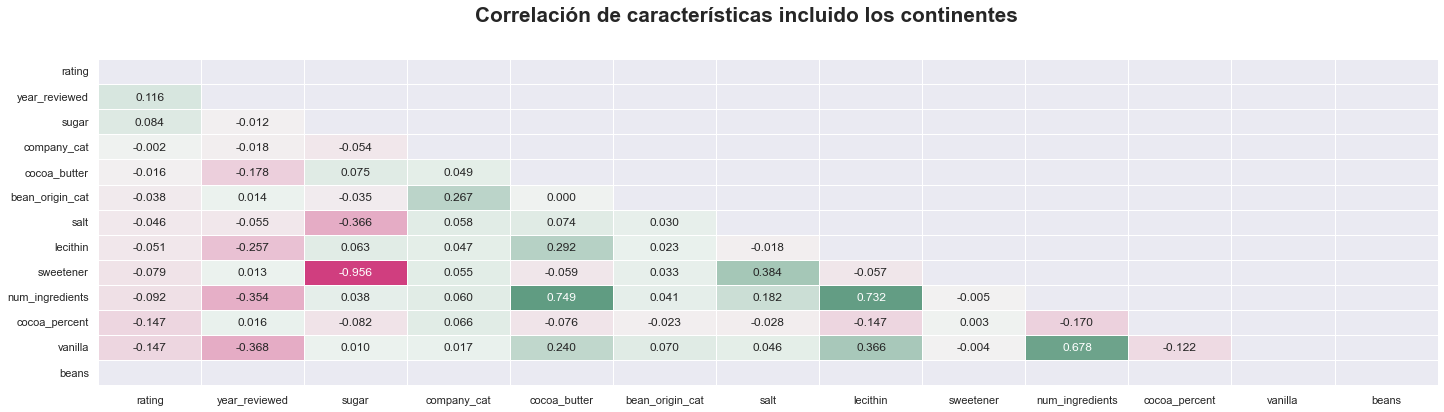

In [27]:
set_figure(24, 6, 'Correlación de características incluido los continentes')
show_corr(data=data.drop(columns=['id']), target='rating')


---

---



---


---



---
### Evaluate feature engineering 2nd iteration models
---

In [28]:

target = 'rating_cat'
target_names = ['Unpleasant', 'Disappointing', 'Recommended', 'Highly Recommended', 'Oustanding']
target_names = None

categorical_features = ['manufacturer', 'company_location', 'bean_origin', 'bar_name', 'ingredientes', 'review']
numeric_features = ['cocoa_percent']
ordinal_features = ['year_reviewed', 'num_ingredients', 'company_cat', 'bean_origin_cat']

base_line_features = numeric_features + ordinal_features + ingredients_features

display(HTML('<hr><h4>Evaluación 2da iteración en ingeniería de características</h4>'))
evaluate_some_models(data, base_line_features, target, target_names)


X_train: (758, 12)
y_train: (758,)
X_test:  (374, 12)
y_test : (374,)


              precision    recall  f1-score   support

           0   0.613636  0.600000  0.606742       180
           1   0.636364  0.649485  0.642857       194

    accuracy                       0.625668       374
   macro avg   0.625000  0.624742  0.624799       374
weighted avg   0.625425  0.625668  0.625475       374



              precision    recall  f1-score   support

           0   0.593220  0.583333  0.588235       180
           1   0.619289  0.628866  0.624041       194

    accuracy                       0.606952       374
   macro avg   0.606255  0.606100  0.606138       374
weighted avg   0.606743  0.606952  0.606808       374

